<a href="https://colab.research.google.com/github/Hitesh-Nagothu/DSA/blob/main/TopicAnalysis_NY_Governer_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Define all the packages to be imported
import json
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing
import re
import string
import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords  

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
sid= SentimentIntensityAnalyzer()

import gensim
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
class Topic_pipeline():

  def __init__(self):
    self.path_to_data='/content/drive/MyDrive/tweet_dfs/en_final.json'
    self.number_of_topics=5
    self.number_of_topic_words=10
    self.tweets_dict={}
    self.tweets_df=pd.DataFrame()
    self.stop_words = set(stopwords.words('english')) 
  
  def create_tweets_dictionary(self):
    """Creates a dictionary from the input json"""
    
    print("Step 1: Creating dictionary from input json \n  ")
    f=open(self.path_to_data)
    self.tweets_dict=json.load(f)
   
  def create_tweets_dataframe(self):
    
    def clean_hashtags(hashtags_dict):
      hashtags=[]
      for item in hashtags_dict:
        hashtags.append(item['text'])

      return hashtags
    
    def clean_urls(urls_dict):
      urls=[]
      for item in urls_dict:
        urls.append(item['url'])
      return urls

    def clean_mentions(mentions_dict):
      mentions=[]
      
      for item in mentions_dict:
        d={}
        d['screen_name']=item['screen_name']
        d['user_id']=item['id_str']
        mentions.append(d)
      return mentions


    self.create_tweets_dictionary()

    """Creates a dataframe from the dictionary"""
    tweets_list=[]
    
    print("Step 2: Creating dataframe from the tweet dictionary \n")
    for tweet in self.tweets_dict:
      info=[]
      id=tweet['id']
      created_at=tweet['created_at']
      raw_text=tweet['full_text']
      retweet_count=tweet['retweet_count']
      fav_count=tweet['favorite_count']
      screen_name=tweet['user']['screen_name']
      name=tweet['user']['name']
      location=tweet['user']['location']
      user_id=tweet['user']['id']
      friends_count=tweet['user']['friends_count']
      followers_count=tweet['user']['followers_count']
      verification_flag=tweet['user']['verified']
      country=tweet['country']
      hashtags=tweet['entities']['hashtags']
      if len(hashtags)==0:
        hashtags=["None"]
      else:
        hashtags=clean_hashtags(hashtags)
      
      urls=tweet['entities']['urls']
      if len(urls)==0:
        urls="None"
      else:
        urls=clean_urls(urls)
      
      mentions=tweet['entities']['user_mentions']
      if len(mentions)==0:
        mentions="None"
      else:
        mentions=clean_mentions(mentions)
            
      if verification_flag is True:
        verified=1
      else:
        verified=0

      lang=tweet['lang']
      info.append([id,created_at,raw_text,urls,hashtags,mentions,retweet_count,fav_count,name,user_id,location,screen_name,friends_count,followers_count,verified,lang,country])
 
      tweets_list.append(info[0])

    self.tweets_df=pd.DataFrame(data=tweets_list,columns=['tweet_id','created_at','text_original','urls','hashtags','mentions','retweet_count','fav_count','name','user_id','location','screen_name','friends_count','followers_count','verified','lang','country'])
    

    print("Step 3: Preprocessing dataframe data \n")
    self.tweets_df['processed_text']=self.tweets_df['text_original'].apply(lambda text: self.preprocess_tweet_df(text))

    print("Step 4: Creating Stemmed tokens for each tweet")
    self.tweets_df['stemmed_tokens']=self.tweets_df['processed_text'].apply(lambda tokens: self.stemming(tokens))
  
    print("Step 5: Preprocessing date values \n")
    self.tweets_df['processed_date']=self.tweets_df['created_at'].apply(lambda date: self.process_dates(date))

    print("Step 6: Creating influencer scores \n")
    self.tweets_df['influencer_score']=self.tweets_df.apply(lambda row: (0.35 * row.retweet_count) + (0.35 * row.followers_count) + (0.15 * row.fav_count) + (0.15 * row.verified), axis=1)
    x = self.tweets_df.influencer_score.values #returns a numpy array
    x=x.reshape(-1,1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    self.tweets_df['normalized_influencer_score'] = pd.DataFrame(x_scaled)

    print("Step 7: Creating sentiment scores \n")
    self.tweets_df['sentiment_scores']=self.tweets_df['processed_text'].apply(lambda tweet: sid.polarity_scores(tweet))
    self.tweets_df['compound_sentiment_scores']=self.tweets_df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
    self.tweets_df['sentiment_type']=self.tweets_df['compound_sentiment_scores'].apply(lambda c: 'pos' if c >=0 else 'neg')

    print("Step 8: Dataframe ready to rock and roll! \n")
    return self.tweets_df


  def preprocess_tweet_df(self,text):
    
    """
    Input: Plain tweet text from df['text_original']~tweet['full_text]
    Output: preprocessed text
    """
    text=re.sub("#[\w]*","",text)                                               #Removing hashtags
    text=re.sub("@[\w]*","",text)                                               #Removing user_mentions
    text=re.sub("https?://[A-Za-z0-9./]*","",text)                                #Removing urls
    text=re.sub("\n","",text)                                                     #Removing multineline space
    word_tokens=word_tokenize(text)                                               #Tokenizing
    filtered_sentence = [w for w in word_tokens if not w in self.stop_words]           #removing stopwords
    filtered_sentence= [w.lower() for w in filtered_sentence]                     #Lowercasing  
    filtered_text=' '.join(filtered_sentence)                           
    filtered_text=re.sub('\w*\d\w*','', filtered_text)                            #Removing any numbers             
    filtered_text = re.sub('[%s]' % re.escape(string.punctuation), '',filtered_text) #Removing any punctuations
    filtered_text= re.sub("\s+",' ',filtered_text)                                   #Removing extra spaces
    return filtered_text

  def stemming(self,text):
    tokenizer=RegexpTokenizer(r'\w+')
    p_stemmer=PorterStemmer()
    texts=[]
    tokens=tokenizer.tokenize(text)
    stemmed_tokens=[p_stemmer.stem(i) for i in tokens]
    if len(stemmed_tokens)>0:
      if stemmed_tokens[0]=='rt':
        stemmed_tokens=stemmed_tokens[1:]

    texts.append(stemmed_tokens)

    return texts[0]

  def process_dates(self,dtime):
     #return datetime.datetime.strftime(datetime.datetime.strptime(dtime,'%a-%b-%dT%H:%M:%SZ'), '%Y-%m-%d')
    return datetime.datetime.strftime(datetime.datetime.strptime(dtime,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d')

    

In [ ]:
poi_data=Topic_pipeline()

In [ ]:
poi_df=poi_data.create_tweets_dataframe()

Step 1: Creating dictionary from input json 
  


FileNotFoundError: ignored

In [ ]:
"""
Important: Perform geo-encoding for public tweets and identify location
"""

'\nImportant: Perform geo-encoding for public tweets and identify location\n'

In [ ]:
poi_df.screen_name.value_counts()

NIHDirector        4000
NYGovCuomo         1819
JoeBiden           1000
markpoloncarz      1000
CDCgov             1000
realDonaldTrump     163
Name: screen_name, dtype: int64

In [ ]:
poi_df['tweet_id'].value_counts()[:2500]

1308594096005697541    3
1308497323044077569    3
1308400185287094274    3
1308539918075883523    3
1308537177903521792    3
                      ..
1314613921182101506    1
1299010020647075841    1
1237032290393313284    1
1319997068765581312    1
1323867320826109954    1
Name: tweet_id, Length: 2500, dtype: int64

In [ ]:
poi_df_non_dup=poi_df.drop_duplicates(subset='tweet_id', keep='first')

In [ ]:
len(poi_df_non_dup)

6913

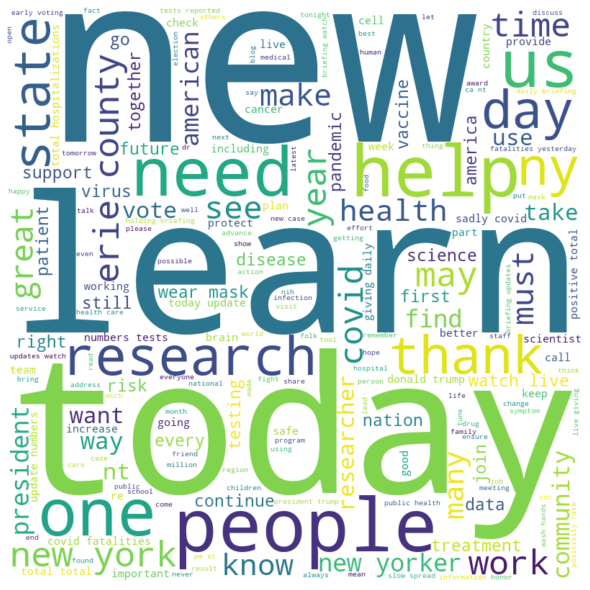

In [ ]:
# Python program to generate WordCloud 

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

# Reads 'Youtube04-Eminem.csv' file 
#df = pd.read_csv(r"Youtube04-Eminem.csv", encoding ="latin-1") 

df=poi_df_non_dup
comment_words = '' 
stopwords = ['rt','amp']+list(STOPWORDS) 


# iterate through the csv file 
for val in df.processed_text: 
	
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


Performing topic analysis using LDA

In [ ]:
poi_df.screen_name.value_counts()

NIHDirector        4000
NYGovCuomo         1819
JoeBiden           1000
markpoloncarz      1000
CDCgov             1000
realDonaldTrump     163
Name: screen_name, dtype: int64

In [ ]:
poi_df.processed_date.value_counts()

2020-10-08    112
2020-10-28     98
2020-09-22     91
2020-11-02     82
2020-11-03     78
             ... 
2020-02-15      1
2020-02-17      1
2020-01-18      1
2020-02-22      1
2020-01-13      1
Name: processed_date, Length: 1091, dtype: int64

In [ ]:
x=poi_df.loc[poi_df.screen_name=='NYGovCuomo']

In [ ]:
time_series={}

def create_time_series(d):
  if d in time_series.keys():
    time_series[d]=time_series[d]+1
  else:
    time_series[d]=1

for index,row in x.iterrows():
  create_time_series(row['processed_date'])
 

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(x=list(time_series.keys()), y=list(time_series.values()))])
fig.show()

In [ ]:
x.columns

Index(['tweet_id', 'created_at', 'text_original', 'urls', 'hashtags',
       'mentions', 'retweet_count', 'fav_count', 'name', 'user_id', 'location',
       'screen_name', 'friends_count', 'followers_count', 'verified', 'lang',
       'country', 'processed_text', 'stemmed_tokens', 'processed_date',
       'influencer_score', 'normalized_influencer_score', 'sentiment_scores',
       'compound_sentiment_scores', 'sentiment_type'],
      dtype='object')

In [ ]:
#Tokenize words and CLean-up text

def sent_to_words(sentence):
    ret=gensim.utils.simple_preprocess(str(sentence), deacc=True)
    return ret
  

x['g_tokenized']=x['processed_text'].apply(lambda text: list(sent_to_words(text)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(x['g_tokenized'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[x['g_tokenized']], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy

In [ ]:
# Remove Stop Words
#data_words_nostops = remove_stopwords(x['g_tokenized'])

# Form Bigrams
data_words_bigrams = make_bigrams(x['g_tokenized'])

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['today', 'of_test', 'report', 'yesterday', 'positive', 'total', 'total', 'sadly', 'covid']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1)]]


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
from pprint import  pprint
pprint(lda_model.print_topics(10))
doc_lda = lda_model[corpus]

[(0,
  '0.048*"must" + 0.019*"home" + 0.018*"good" + 0.017*"provide" + '
  '0.017*"great" + 0.016*"keep" + 0.015*"american" + 0.014*"nyer" + '
  '0.013*"pay" + 0.013*"travel"'),
 (1,
  '0.066*"update" + 0.033*"watch" + 0.027*"step" + 0.022*"giving_daily" + '
  '0.019*"school" + 0.018*"include" + 0.018*"mask" + 0.013*"supply" + '
  '0.013*"reopen" + 0.012*"forget"'),
 (2,
  '0.023*"honor" + 0.021*"year" + 0.019*"family" + 0.016*"today" + '
  '0.016*"rican" + 0.015*"way" + 0.015*"hold" + 0.013*"emergency" + '
  '0.013*"future" + 0.013*"bring"'),
 (3,
  '0.035*"protect" + 0.033*"spread" + 0.027*"first" + 0.021*"full" + '
  '0.021*"brief" + 0.021*"remain" + 0.017*"response" + 0.015*"save_live" + '
  '0.015*"open" + 0.014*"staff"'),
 (4,
  '0.051*"need" + 0.021*"thank" + 0.020*"stay" + 0.019*"direct" + 0.017*"see" '
  '+ 0.017*"safe" + 0.014*"support" + 0.014*"lab" + 0.014*"sign" + '
  '0.012*"tool"'),
 (5,
  '0.062*"today" + 0.036*"positive" + 0.025*"total" + 0.024*"covid" + '
  '0.022*"la

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.981310801629348

Coherence Score:  0.46885850598636086


In [ ]:


import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.378004  0.035602       1        1  26.982590
4     -0.113870  0.248406       2        1  14.629200
0      0.016198  0.072290       3        1  11.905602
1     -0.065503  0.034804       4        1  10.709149
2     -0.034708 -0.278389       5        1   9.717267
7     -0.018421 -0.033519       6        1   8.819155
3     -0.092334 -0.007130       7        1   8.742073
5     -0.069365 -0.072063       8        1   8.494965, topic_info=         Term        Freq       Total Category  logprob  loglift
298    update  133.000000  133.000000  Default  30.0000  30.0000
466     state  237.000000  237.000000  Default  29.0000  29.0000
55       need  139.000000  139.000000  Default  28.0000  28.0000
24        new  208.000000  208.000000  Default  27.0000  27.0000
5       today  128.000000  128.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
330  reminder    9.727944   10.359560   Topic8  -5.0978   2.4028
5       today   98.035759  128.540459   Topic8  -2.7874   2.1948
641    damage   28.365031   45.677344   Topic8  -4.0276   1.9893
104    number   20.390365   31.934024   Topic8  -4.3577   2.0171
92       lose   14.550786   31.835651   Topic8  -4.6951   1.6828

[299 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3526      5  0.986372  achievement
827       6  0.990786          act
367       2  0.978895       action
1120      6  0.971265   additional
333       2  0.963144        allow
...     ...       ...          ...
284       1  0.803789         work
284       3  0.189658         work
28        5  0.987709         year
7         8  0.955994    yesterday
1103      2  0.982950       yorker

[288 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 1, 2, 3, 8, 4, 6])

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

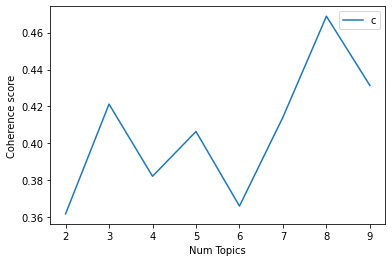

In [ ]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3618
Num Topics = 3  has Coherence Value of 0.4212
Num Topics = 4  has Coherence Value of 0.3822
Num Topics = 5  has Coherence Value of 0.4064
Num Topics = 6  has Coherence Value of 0.366
Num Topics = 7  has Coherence Value of 0.4142
Num Topics = 8  has Coherence Value of 0.4689
Num Topics = 9  has Coherence Value of 0.4313


In [ ]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

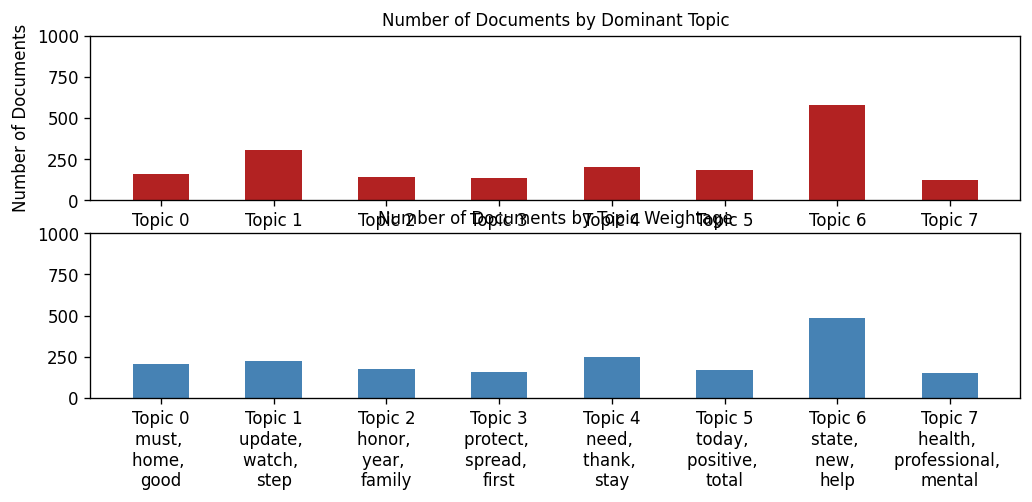

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1146 samples in 0.001s...
[t-SNE] Computed neighbors for 1146 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1146
[t-SNE] Computed conditional probabilities for sample 1146 / 1146
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.377693
[t-SNE] KL divergence after 1000 iterations: 0.477412


In [ ]:
import matplotlib.colors as mcolors